# Dimensionality reduction using SVD/PCA

Let's take a concrete example and walk through dimensionality reduction using *singular value decomposition* (SVD) and *principal component analysis* (PCA), as presented in the Jurafsky & Martin book:

![](../src/jurafsky_martin_fig16.3svd.png)

What is the difference between SVD and PCA?

SVD (in Step 1 above) states that any matrix (such as X) can be factorized into three matrices (such as W, $\Sigma$ and C). $\Sigma$ is a diagonal matrix with non-zero values on the diagonal only (called *singular values*) and zeros in every other position.

PCA (in Step 2 above) works like SVD, but additionally it drops the least important *components* (which are vectors in matrix C). By doing this, PCA approximates the original matrix X and reduces the dimensionality of matrices W, $\Sigma$ and C. As a biproduct of dimensionality reduction, we can obtain useful, and more compact, vector reprentations for the words in our vocabulary (Step 3).

This sounds rather abstract, so we'll move on to our concrete example.

First we need to import some Python libraries:

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

np.set_printoptions(precision=2, suppress=True) # Print floating point numbers with two decimals only

Our vocabulary of words that we will analyze consists of the following six words:

In [2]:
vocab = [ "apple", "candy", "garum", "lemon", "lemonade", "tabasco" ]
w = len(vocab)

Since there are six words, the value of `w` (Fig. 16.3 above) is 6.

Let's pretend we have some statistics collected from a corpus, which tells us how often the words in our vocabulary co-occur with a set of other words, which are our context features:

In [3]:
context_features = [ "enjoy", "garden", "hungry", "intense", "more", "natural", "salt", "sour", "sugar", "vitamin" ]
c = len(context_features)

There are 10 context words, which means that the value of `c` (Fig 16.3) is 10 in our case.

Below we can see a co-occurrence matrix, with `w = 6` rows and `c = 10` columns. The vocabulary words are represented by rows and the context words by columns. The co-occurrence values may be simple word counts or something more complex, like PPMI values. Let us assume that we deal with simple co-occurrence counts. For instance, we can read from the matrix that "natural" has occurred 9 times in the context of "apple": 

In [4]:
#                                    i       n               v
#                            g   h   n       a               i
#                        e   a   u   t       t           s   t
#                        n   r   n   e   m   u   s   s   u   a
#                        j   d   g   n   o   r   a   o   g   m
#                        o   e   r   s   r   a   l   u   a   i
#                        y   n   y   e   e   l   t   r   r   n

wc_matrix = np.array([[  5, 10,  5,  0,  4,  9,  0,  2,  5,  7 ],    # apple
                      [ 12,  0,  9,  0, 10,  0,  2,  0, 13,  0 ],    # candy
                      [  0,  0,  0, 12,  0,  0, 10,  5,  0,  1 ],    # garum
                      [  0,  6,  0, 10,  0,  8,  0, 11,  1, 15 ],    # lemon                    
                      [  9,  1,  4,  0,  6,  3,  0,  1,  9,  3 ],    # lemonade
                      [  0,  0,  0, 14,  1,  0,  7,  7,  1,  0 ]])   # tabasco

print(wc_matrix)

[[ 5 10  5  0  4  9  0  2  5  7]
 [12  0  9  0 10  0  2  0 13  0]
 [ 0  0  0 12  0  0 10  5  0  1]
 [ 0  6  0 10  0  8  0 11  1 15]
 [ 9  1  4  0  6  3  0  1  9  3]
 [ 0  0  0 14  1  0  7  7  1  0]]


Next, we will plot the word vectors of our vocabulary in a graph. However, since we have `c = 10` dimensions, we cannot view the whole matrix in one go. Instead, we project the vectors into two dimensions. That is, we pick some 2D "slices" or planes from the 10D space.

We need to pick two context features at a time and plot the vocabulary in those two dimensions only. Below you can see plots for the dimension pairs: (sugar, hungry), (sugar, vitamin), (sugar, intense). There are many more possible slices, which we do not plot.

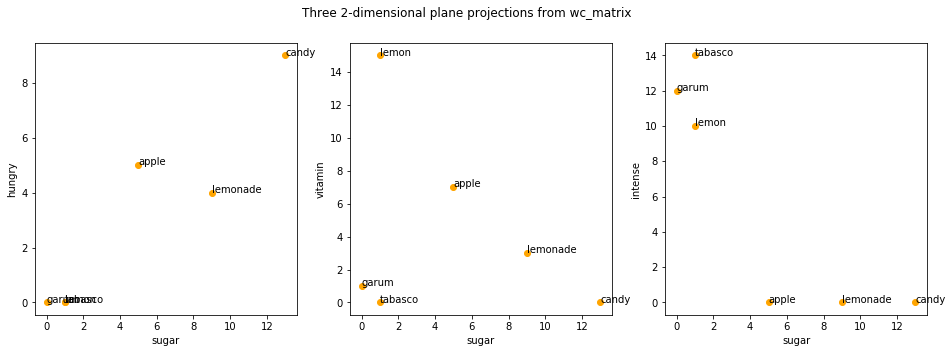

In [5]:
def plot_words(x, y, M):
    """ From the word and feature values in matrix M,
        for all words in the vocabulary,
        plot the x:th feature dimension on the x axis
        and the y:th feature dimension on the y axis
    """
    # Plot the dots
    plt.plot(M[:,x], M[:,y], color="orange", marker="o", linestyle="")
    # Label the axes
    plt.xlabel(context_features[x])
    plt.ylabel(context_features[y])
    # Add word labels to the dots
    for i, label in enumerate(vocab):
        plt.annotate(label, (M[i, x], M[i, y]))
    
# Create three subplots
    
plt.figure(figsize=(16, 5))

plt.suptitle("Three 2-dimensional plane projections from wc_matrix")

plt.subplot(131)
plot_words(8, 2, wc_matrix) # 8 = sugar, 2 = hungry
    
plt.subplot(132)
plot_words(8, 9, wc_matrix) # 8 = sugar, 9 = vitamin
    
plt.subplot(133)
plot_words(8, 3, wc_matrix) # 8 = sugar, 3 = intense

plt.show()

What is the relationship between our `wc_matrix` and the matrix X in Fig. 16.3 above? Are they the same?

As a matter of fact, we need the mean value on every feature dimension to be zero. For instance, now the mean value along the *enjoy* dimension is (5 + 12 + 0 + 0 + 9 + 0)/6 = 4.33. We need to subtract this mean from every value along the *enjoy* dimension to get a new mean value that is zero: 

In [6]:
# Compute the mean value along every feature dimension
f_mean = np.mean(wc_matrix, 0)
print("Feature-specific means:", f_mean)
print()

# Create a new matrix X, in which the feature dimension's mean has been subtracted from every value
print("Matrix X (after centering means around origin):")
X = wc_matrix - f_mean
print(X)
print()

# To verify, compute the new mean values for the feature dimensions in X
print("Verify that the means of the dimensions in X are zero:", np.mean(X, 0))

Feature-specific means: [ 4.33  2.83  3.    6.    3.5   3.33  3.17  4.33  4.83  4.33]

Matrix X (after centering means around origin):
[[  0.67   7.17   2.    -6.     0.5    5.67  -3.17  -2.33   0.17   2.67]
 [  7.67  -2.83   6.    -6.     6.5   -3.33  -1.17  -4.33   8.17  -4.33]
 [ -4.33  -2.83  -3.     6.    -3.5   -3.33   6.83   0.67  -4.83  -3.33]
 [ -4.33   3.17  -3.     4.    -3.5    4.67  -3.17   6.67  -3.83  10.67]
 [  4.67  -1.83   1.    -6.     2.5   -0.33  -3.17  -3.33   4.17  -1.33]
 [ -4.33  -2.83  -3.     8.    -2.5   -3.33   3.83   2.67  -3.83  -4.33]]

Verify that the means of the dimensions in X are zero: [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0.]


Now we have a matrix `X` corresponding to X in Fig 16.3. Let's plot the words from this new matrix:

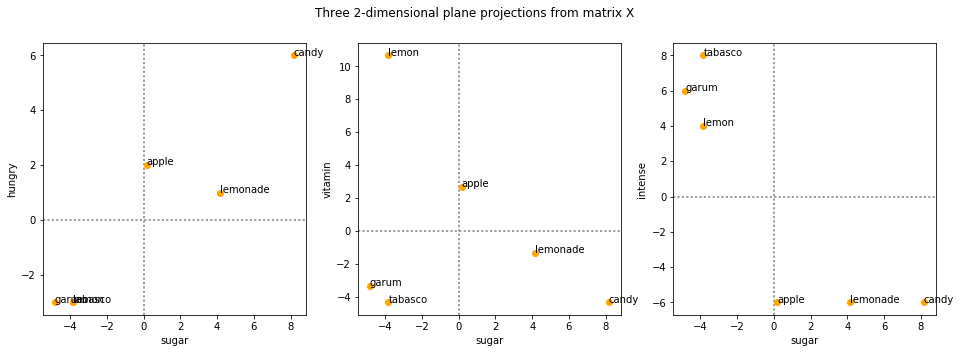

In [7]:
def plot_words_with_zero_lines(x, y, M):
    """ From the word and feature values in matrix M,
        for all words in the vocabulary,
        plot the x:th feature dimension on the x axis
        and the y:th feature dimension on the y axis
    """
    # Draw dotted lines at x = 0 and y = 0
    plt.gca().axhline(0, linestyle=':', color='gray')
    plt.gca().axvline(0, linestyle=':', color='gray')

    # Plot the words as above
    plot_words(x, y, M)
    
# Create three subplots

plt.figure(figsize=(16, 5))

plt.suptitle("Three 2-dimensional plane projections from matrix X")

plt.subplot(131)
plot_words_with_zero_lines(8, 2, X) # 8 = sugar, 2 = hungry
    
plt.subplot(132)
plot_words_with_zero_lines(8, 9, X) # 8 = sugar, 9 = vitamin
    
plt.subplot(133)
plot_words_with_zero_lines(8, 3, X) # 8 = sugar, 3 = intense

plt.show()

The graphs look the same as before. The only thing that has changed are the axes. The origin has been shifted from the lower left corner upwards to the right (where the two dotted lines cross). This means that we haven't distorted our data.

Next we will run the SVD/PCA algorithm on matrix `X`. We will not dive into the details on how to solve all the equations. We will just use existing software. As the number of singular values `m` (from Fig. 16.3) we will use as large a value as possible, such that `m <= min(w, c)`. Hence, `m = 6`.

The calculations will produce three new matrices: `W`, `Sigma` and `C` (as in Fig. 16.3):

In [8]:
m = 6
pca = PCA(n_components=m, svd_solver="full")
W_dot_Sigma = pca.fit_transform(X)
sigmas = pca.singular_values_

W = W_dot_Sigma / sigmas
Sigma = np.diag(sigmas)

C = pca.components_

print("Matrix W:\n", W)
print()

print("Matrix Sigma:\n", Sigma)
print()

print("Matrix C:\n", C)

Matrix W:
 [[ 0.19  0.49  0.71 -0.2   0.12  0.41]
 [ 0.61 -0.27 -0.32 -0.51 -0.19  0.41]
 [-0.38 -0.41  0.3   0.14 -0.64  0.41]
 [-0.4   0.6  -0.53 -0.07 -0.15  0.41]
 [ 0.37 -0.01 -0.13  0.81  0.15  0.41]
 [-0.39 -0.4  -0.02 -0.17  0.7   0.41]]

Matrix Sigma:
 [[ 26.67   0.     0.     0.     0.     0.  ]
 [  0.    19.65   0.     0.     0.     0.  ]
 [  0.     0.     7.47   0.     0.     0.  ]
 [  0.     0.     0.     3.63   0.     0.  ]
 [  0.     0.     0.     0.     2.7    0.  ]
 [  0.     0.     0.     0.     0.     0.  ]]

Matrix C:
 [[ 0.43 -0.01  0.3  -0.53  0.33 -0.01 -0.2  -0.31  0.43 -0.15]
 [-0.04  0.43  0.   -0.23 -0.06  0.47 -0.38  0.14 -0.04  0.61]
 [-0.2   0.51  0.02 -0.27 -0.16  0.23  0.29 -0.43 -0.32 -0.42]
 [ 0.06 -0.44 -0.64 -0.4  -0.32  0.02 -0.23 -0.25 -0.15  0.02]
 [-0.09  0.17 -0.17  0.24  0.09  0.13 -0.69  0.17  0.05 -0.58]
 [-0.17 -0.52  0.53 -0.12  0.1   0.34 -0.16  0.04 -0.49 -0.08]]


If our calculations are correct, we should be able to reconstruct the matrix X by multiplying these three new matrices together (using the dot product):

In [9]:
print("W dot Sigma dot C:")
print(np.dot(np.dot(W, Sigma), C))
print()

print("Matrix X:")
print(X)

W dot Sigma dot C:
[[  0.67   7.17   2.    -6.     0.5    5.67  -3.17  -2.33   0.17   2.67]
 [  7.67  -2.83   6.    -6.     6.5   -3.33  -1.17  -4.33   8.17  -4.33]
 [ -4.33  -2.83  -3.     6.    -3.5   -3.33   6.83   0.67  -4.83  -3.33]
 [ -4.33   3.17  -3.     4.    -3.5    4.67  -3.17   6.67  -3.83  10.67]
 [  4.67  -1.83   1.    -6.     2.5   -0.33  -3.17  -3.33   4.17  -1.33]
 [ -4.33  -2.83  -3.     8.    -2.5   -3.33   3.83   2.67  -3.83  -4.33]]

Matrix X:
[[  0.67   7.17   2.    -6.     0.5    5.67  -3.17  -2.33   0.17   2.67]
 [  7.67  -2.83   6.    -6.     6.5   -3.33  -1.17  -4.33   8.17  -4.33]
 [ -4.33  -2.83  -3.     6.    -3.5   -3.33   6.83   0.67  -4.83  -3.33]
 [ -4.33   3.17  -3.     4.    -3.5    4.67  -3.17   6.67  -3.83  10.67]
 [  4.67  -1.83   1.    -6.     2.5   -0.33  -3.17  -3.33   4.17  -1.33]
 [ -4.33  -2.83  -3.     8.    -2.5   -3.33   3.83   2.67  -3.83  -4.33]]


The matrices are identical, which means two things: We did the calculations correctly and we have not lost any precision by factorizing matrix X into a product of three smaller matrices. That is, we have run full SVD successfully.

This may still sound theoretical and abstract, so let's move on to the interpretation.

### Latent semantic dimensions and principal components

Matrix `wc_matrix` contains the co-occurrence counts of words with other words. Assume that by looking at the data, we are only observing a *surface realization* of some interesting *underlying phenomenon*. The presence of the context words is a mere symptom, or manifestation, of some underlying process. In this underlying process there are hidden, *latent semantic dimensions*. Our task is to unveil these latent semantic features.

How many latent semantic dimensions are there? The maximum number is the number of singular values `m`, which is 6 in our case. Let's look at the singular values:

In [10]:
print("Singular values:", sigmas)

Singular values: [ 26.67  19.65   7.47   3.63   2.7    0.  ]


These numbers indicate the weight or importance of each uncovered latent dimension. Each dimension is represented by a vector, called a _principal component_ (PC). The PCs are ordered by importance. The PCs are in the rows of matrix C:

In [11]:
print("Showing singular values together with their associated principal component vectors:\n")

for i in range(0, m):
    print("Singular value {:d}: {:.2f}".format(i + 1, sigmas[i]))
    print("PC {:d}:".format(i + 1), C[i])
    print()

Showing singular values together with their associated principal component vectors:

Singular value 1: 26.67
PC 1: [ 0.43 -0.01  0.3  -0.53  0.33 -0.01 -0.2  -0.31  0.43 -0.15]

Singular value 2: 19.65
PC 2: [-0.04  0.43  0.   -0.23 -0.06  0.47 -0.38  0.14 -0.04  0.61]

Singular value 3: 7.47
PC 3: [-0.2   0.51  0.02 -0.27 -0.16  0.23  0.29 -0.43 -0.32 -0.42]

Singular value 4: 3.63
PC 4: [ 0.06 -0.44 -0.64 -0.4  -0.32  0.02 -0.23 -0.25 -0.15  0.02]

Singular value 5: 2.70
PC 5: [-0.09  0.17 -0.17  0.24  0.09  0.13 -0.69  0.17  0.05 -0.58]

Singular value 6: 0.00
PC 6: [-0.17 -0.52  0.53 -0.12  0.1   0.34 -0.16  0.04 -0.49 -0.08]



The two first PCs have rather high singular values: 26.67 and 19.65. There is a significant drop to the next three PCs: 7.47, 3.63, and 2.70.

The sixth singular value is zero. This means that the sixth PC has no weigth at all and is _superfluous_ in the model. Hence our matrix X can be factorized fully and losslessly into three matrices W, $\Sigma$, and C, using just 5 dimensions. The 10 context words ("enjoy", "garden", "hungry", ...) are a manifestation of an underlying process with just 5 *uncorrelated* latent dimensions.

### What do the principal components mean?

To be able to interpret the "meaning" of each principal component, we need to understand that each of the ten dimensions in the PC vector corresponds to a context feature word: "enjoy", "garden", "hungry", ... Thus, the principal component is a mix of features, where each feature is weighted differently. A bit like this:

In [12]:
for i in range(0, 5):
    print("PC {:d} =".format(i + 1))
    print(" + ".join('{:.2f} * "{:s}"'.format(v, wrd) for v, wrd in zip(C[i], context_features)))
    print()

PC 1 =
0.43 * "enjoy" + -0.01 * "garden" + 0.30 * "hungry" + -0.53 * "intense" + 0.33 * "more" + -0.01 * "natural" + -0.20 * "salt" + -0.31 * "sour" + 0.43 * "sugar" + -0.15 * "vitamin"

PC 2 =
-0.04 * "enjoy" + 0.43 * "garden" + 0.00 * "hungry" + -0.23 * "intense" + -0.06 * "more" + 0.47 * "natural" + -0.38 * "salt" + 0.14 * "sour" + -0.04 * "sugar" + 0.61 * "vitamin"

PC 3 =
-0.20 * "enjoy" + 0.51 * "garden" + 0.02 * "hungry" + -0.27 * "intense" + -0.16 * "more" + 0.23 * "natural" + 0.29 * "salt" + -0.43 * "sour" + -0.32 * "sugar" + -0.42 * "vitamin"

PC 4 =
0.06 * "enjoy" + -0.44 * "garden" + -0.64 * "hungry" + -0.40 * "intense" + -0.32 * "more" + 0.02 * "natural" + -0.23 * "salt" + -0.25 * "sour" + -0.15 * "sugar" + 0.02 * "vitamin"

PC 5 =
-0.09 * "enjoy" + 0.17 * "garden" + -0.17 * "hungry" + 0.24 * "intense" + 0.09 * "more" + 0.13 * "natural" + -0.69 * "salt" + 0.17 * "sour" + 0.05 * "sugar" + -0.58 * "vitamin"



PC 1 has fairly strong positive correlation with "sugar", "enjoy", "more" and "hungry". By contrast, PC 1 is negatively correlated with "intense", "sour" and "salt".

PC 2 is positively correlated with especially "vitamin", "natural" and "garden", and negatively correlated with "salt" and "intense".

What does this sound like? Could we hypothetically claim that PC 1 is related to the concept of **tastiness** and PC 2 to **healthiness**?

Since the first singular value (26.67) is greater than the second one (19.65), it means that *tastiness* is more strongly present in our data than *healthiness*. Furthermore, since the next singular values are much smaller (< 10), we decide to drop the rest of the PCs, in the spirit of PCA.

By keeping the two first principal components only (k = 2 in Fig. 16.3), we suggest that our six words in the vocabulary (apple, candy, garum, lemon, lemonade, tabasco) can be described in terms of two latent semantic dimensions (tastiness and healthiness) without losing much precision.

Let's project these two principal components into the *original space* of matrix X:

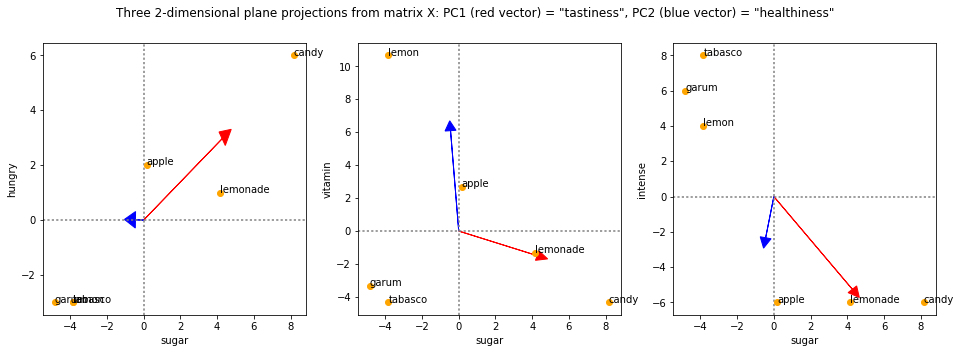

In [13]:
def plot_words_with_2_principal_components(x, y, M):
    """ From the word and feature values in matrix M,
        for all words in the vocabulary,
        plot the x:th feature dimension on the x axis
        and the y:th feature dimension on the y axis
    """
    # Draw dotted lines at x = 0 and y = 0
    plt.gca().axhline(0, linestyle=':', color='gray')
    plt.gca().axvline(0, linestyle=':', color='gray')

    # Draw vectors representing the 2 principal components
    scale = 10
    plt.gca().arrow(0, 0, scale * C[0, x], scale * C[0, y],
                    head_width=0.6, head_length=0.6, color="red")
    plt.gca().arrow(0, 0, scale * C[1, x], scale * C[1, y],
                    head_width=0.6, head_length=0.6, color="blue")
    
    # Plot the words as above
    plot_words(x, y, M)

# Create three subplots

plt.figure(figsize=(16, 5))

plt.suptitle('Three 2-dimensional plane projections from matrix X: ' +
             'PC1 (red vector) = "tastiness", PC2 (blue vector) = "healthiness"')

plt.subplot(131)
plot_words_with_2_principal_components(8, 2, X) # 8 = sugar, 2 = hungry
    
plt.subplot(132)
plot_words_with_2_principal_components(8, 9, X) # 8 = sugar, 9 = vitamin
    
plt.subplot(133)
plot_words_with_2_principal_components(8, 3, X) # 8 = sugar, 3 = intense

plt.show()    

The red arrows show what directions to move in order to reach higher tastiness, and the blue arrows show the directions of higher healthiness.

We can now move to the new two-dimensional space spanned by the two principal components. Tastiness is on the x axis and healthiness is on the y axis:

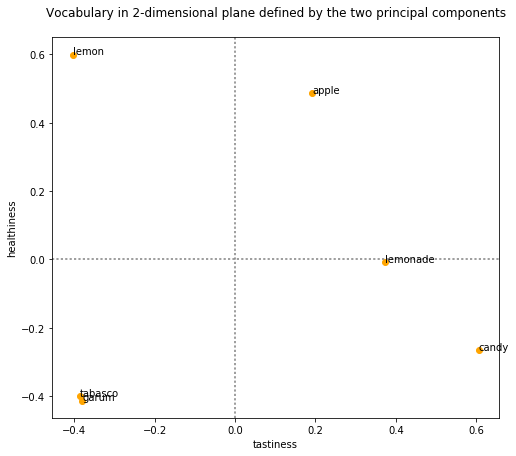

In [14]:
def plot_words_in_pca_space():
    plt.figure(figsize=(8, 7))
    plt.plot(W[:,0], W[:,1], color="orange", marker="o", linestyle="")
    plt.gca().axhline(0, linestyle=':', color='gray')
    plt.gca().axvline(0, linestyle=':', color='gray')
    plt.xlabel("tastiness")
    plt.ylabel("healthiness")
    for i, label in enumerate(vocab):
        plt.annotate(label, (W[i, 0], W[i, 1]))

plot_words_in_pca_space()
plt.title("Vocabulary in 2-dimensional plane defined by the two principal components\n")
plt.show()

The above plot illustrates what happens if we move from representing the vocabulary using context words (matrix X) to a denser representations in the space defined by $W_k$ in Fig. 16.3:

In [21]:
print("Old coordinates (before dimensionality reduction):")
for i in range(0, w):
    print(vocab[i], "=", X[i, :])
print()

print("New coordinates (after dimensionality reduction):")
for i in range(0, w):
    print(vocab[i], "=", W[i, 0:2])

Old coordinates (before dimensionality reduction):
apple = [ 0.67  7.17  2.   -6.    0.5   5.67 -3.17 -2.33  0.17  2.67]
candy = [ 7.67 -2.83  6.   -6.    6.5  -3.33 -1.17 -4.33  8.17 -4.33]
garum = [-4.33 -2.83 -3.    6.   -3.5  -3.33  6.83  0.67 -4.83 -3.33]
lemon = [ -4.33   3.17  -3.     4.    -3.5    4.67  -3.17   6.67  -3.83  10.67]
lemonade = [ 4.67 -1.83  1.   -6.    2.5  -0.33 -3.17 -3.33  4.17 -1.33]
tabasco = [-4.33 -2.83 -3.    8.   -2.5  -3.33  3.83  2.67 -3.83 -4.33]

New coordinates (after dimensionality reduction):
apple = [ 0.19  0.49]
candy = [ 0.61 -0.27]
garum = [-0.38 -0.41]
lemon = [-0.4  0.6]
lemonade = [ 0.37 -0.01]
tabasco = [-0.39 -0.4 ]


Or expressed more verbously, and with the inclusion of the singular values (26.67 and 19.65), we get:

In [20]:
print("New interpretation:")
for i in range(0, w):
    print("{:s} = {:.2f} * {:.2f} * tastiness + {:.2f} * {:.2f} * healthiness"
              .format(vocab[i], W[i, 0],  sigmas[0], W[i, 1], sigmas[1]))

New interpretation:
apple = 0.19 * 26.67 * tastiness + 0.49 * 19.65 * healthiness
candy = 0.61 * 26.67 * tastiness + -0.27 * 19.65 * healthiness
garum = -0.38 * 26.67 * tastiness + -0.41 * 19.65 * healthiness
lemon = -0.40 * 26.67 * tastiness + 0.60 * 19.65 * healthiness
lemonade = 0.37 * 26.67 * tastiness + -0.01 * 19.65 * healthiness
tabasco = -0.39 * 26.67 * tastiness + -0.40 * 19.65 * healthiness


Finally, we can project vectors for the context feature words into the new two-dimensional space:

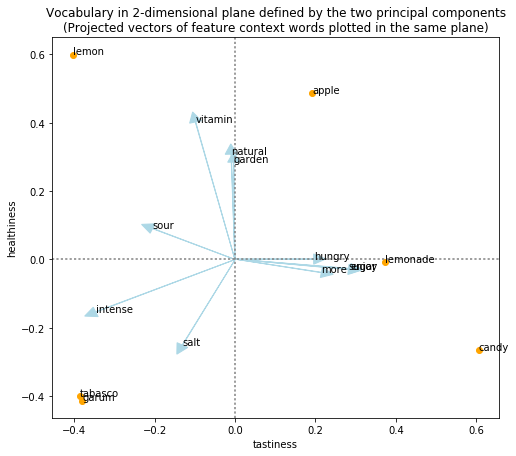

In [17]:
plot_words_in_pca_space()
plt.title("Vocabulary in 2-dimensional plane defined by the two principal components\n" +
          "(Projected vectors of feature context words plotted in the same plane)")
# Add vectors representing the context feature words in this space
scale = 0.66
for i, label in enumerate(context_features):
    plt.gca().arrow(0, 0, scale * C[0, i], scale * C[1, i],
                    head_width=0.03, head_length=0.03, color="lightblue")
    plt.annotate(label, (scale * C[0, i], scale * C[1, i]))
plt.show()

By looking at these feature word vectors, we understand why the principal components were chosen to be what they are.

We see four vectors ("hungry", "more", "enjoy", "sugar") strongly correlated and pointing almost in the same direction. This direction has been chosen as the first principal component ("tastiness"), which is plotted along the x axis.

We see two other vectors ("natural", "garden") perpendicular to "tastiness". Additionally, the vector for "vitamin" points in almost the same direction. These three correlated vectors have formed a basis for the second principal component ("healthiness"), which is plotted along the y axis.

The remaining vectors ("sour", "intense", "salt") are more spread out, at least in this projection. "Sour" and "intense" seem to contribute to the opposite of tastiness ("tastes bad"). Especially "salt" seems to contribute to "unhealthiness".